In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import Pipeline
from sksurv.util import Surv
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = 'Times New Roman'
np.random.seed(42)

def simulate_survival_data(n_observations = 1000, n_events = 100, min_time = 12, max_time = 120):
    # This function simulates random survival data with model scores for n_observations with n_events many events.
    # We can tweak the separation between model scores by changing the loc and scale of the normal distribution
    time = np.random.choice(np.arange(min_time, max_time+1), size=n_observations) # randomly selecting time-intervals 
    
    event = np.zeros((n_observations,)) 
    event[:n_events] = 1        

    score = np.zeros(n_observations,)
    score[event == 1] = np.random.normal(loc=0.55, scale=0.2, size=np.sum(event == 1)) # normal probs for events
    score[event == 0] = np.random.normal(loc=0.45, scale=0.2, size=np.sum(event == 0)) # normal probs for censored events
    score = np.clip(score, 0, 1) 
    
    indices = np.arange(n_observations)
    np.random.shuffle(indices)
    time = time[indices]
    event = event[indices]
    score = score[indices]
    
    return time, event.astype('bool'), score

time, event, model_score = simulate_survival_data(n_observations = 2000, n_events = 200, min_time = 12, max_time = 120)

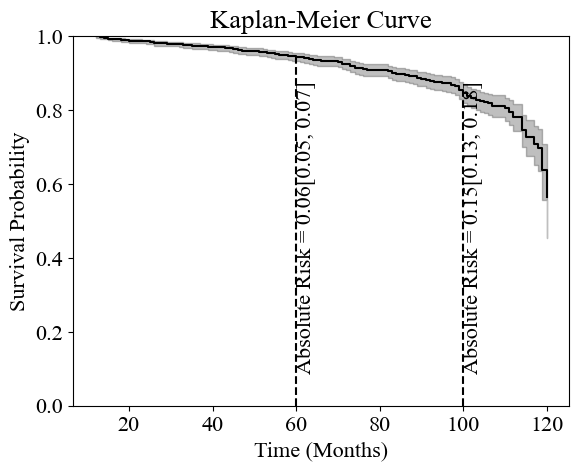

In [3]:
################ Kaplan-Meier Curve ###########
xx, yy, conf_int = kaplan_meier_estimator(event, time, conf_type="log-log")
plt.step(xx, yy, where="post", color = 'k')
plt.fill_between(xx, conf_int[0], conf_int[1], color = 'k', alpha=0.25, step="post")
idx = int(np.argmin(np.abs(xx-60)))
absolute_prob = yy[idx]
absolute_prob_ci = [conf_int[1,idx], conf_int[0,idx]]
plt.plot([xx[idx],xx[idx]],[0,absolute_prob],'--k')
plt.text(xx[idx],0.1,'Absolute Risk = '+str(np.round(1-absolute_prob,2))+'['+str(np.round(1-absolute_prob_ci[0],2))+', '+str(np.round(1-absolute_prob_ci[1],2))+']', rotation = 90)
idx = int(np.argmin(np.abs(xx-100)))
absolute_prob = yy[idx]
absolute_prob_ci = [conf_int[1,idx], conf_int[0,idx]]
plt.plot([xx[idx],xx[idx]],[0,absolute_prob],'--k')
plt.text(xx[idx],0.1,'Absolute Risk = '+str(np.round(1-absolute_prob,2))+'['+str(np.round(1-absolute_prob_ci[0],2))+', '+str(np.round(1-absolute_prob_ci[1],2))+']', rotation = 90)
plt.ylim(0, 1)
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Curve')
plt.show()
del xx, yy, conf_int,idx,absolute_prob,absolute_prob_ci

In [4]:
################ Concordance Index ###########
from sksurv.metrics import concordance_index_censored
c_index = concordance_index_censored(event, time, model_score)
print('c-index = ' +str(np.round(c_index[0],2)))

c-index = 0.65


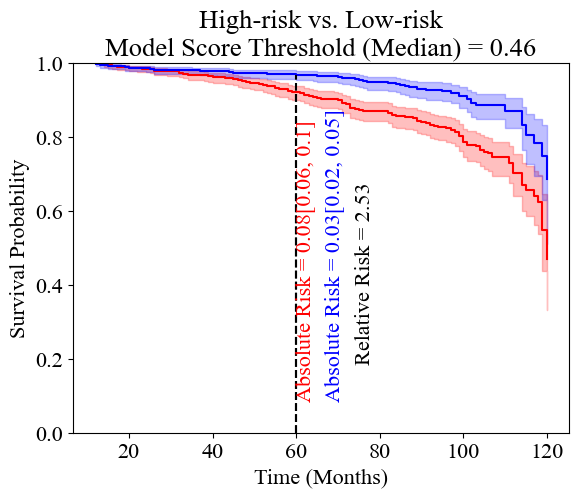

In [5]:
################ Kaplan-Meier Curve Score Cutoff ###########
score_cutoff = np.median(model_score)
xx, yy, conf_int = kaplan_meier_estimator(event[model_score>=score_cutoff], time[model_score>=score_cutoff], conf_type="log-log")
plt.step(xx, yy, where="post", color = 'r')
plt.fill_between(xx, conf_int[0], conf_int[1], color = 'r', alpha=0.25, step="post")
idx = int(np.argmin(np.abs(xx-60)))
absolute_prob = yy[idx]
absolute_prob_ci = [conf_int[1,idx], conf_int[0,idx]]
plt.plot([xx[idx],xx[idx]],[0,absolute_prob],'--k')
plt.text(xx[idx],0.1,'Absolute Risk = '+str(np.round(1-absolute_prob,2))+'['+str(np.round(1-absolute_prob_ci[0],2))+', '+str(np.round(1-absolute_prob_ci[1],2))+']', rotation = 90, c= 'r')
relative_risk = [1-absolute_prob]

xx, yy, conf_int = kaplan_meier_estimator(event[model_score<score_cutoff], time[model_score<score_cutoff], conf_type="log-log")
plt.step(xx, yy, where="post", color = 'b')
plt.fill_between(xx, conf_int[0], conf_int[1], color = 'b', alpha=0.25, step="post")
idx = int(np.argmin(np.abs(xx-60)))
absolute_prob = yy[idx]
absolute_prob_ci = [conf_int[1,idx], conf_int[0,idx]]
plt.plot([xx[idx],xx[idx]],[0,absolute_prob],'--k')
plt.text(xx[idx]+7,0.1,'Absolute Risk = '+str(np.round(1-absolute_prob,2))+'['+str(np.round(1-absolute_prob_ci[0],2))+', '+str(np.round(1-absolute_prob_ci[1],2))+']', rotation = 90, c = 'b')
relative_risk.append(1-absolute_prob)

relative_risk = relative_risk[0]/relative_risk[1]
plt.text(xx[idx]+14,0.2,'Relative Risk = '+str(np.round(relative_risk,2)), rotation = 90, c = 'k')
plt.ylim(0, 1)
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('High-risk vs. Low-risk'+'\n'+'Model Score Threshold (Median) = '+str(np.round(score_cutoff,2)))
plt.show()
del xx, yy, conf_int,absolute_prob,absolute_prob_ci,idx,relative_risk

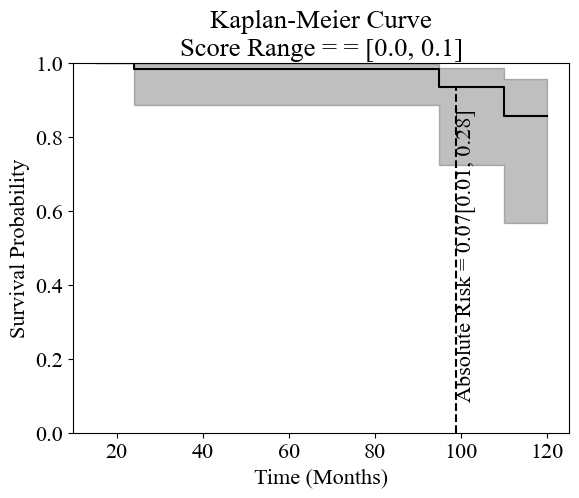

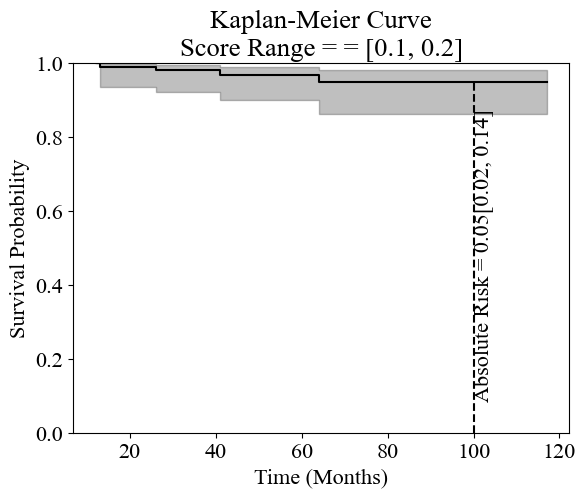

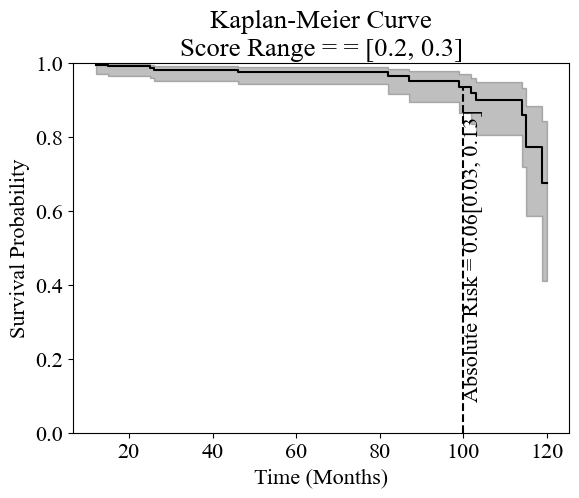

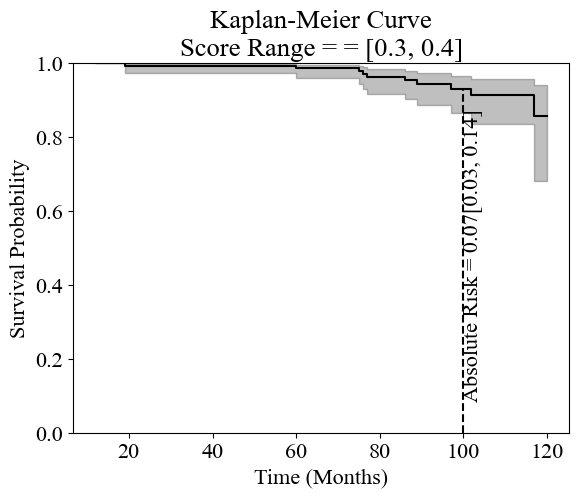

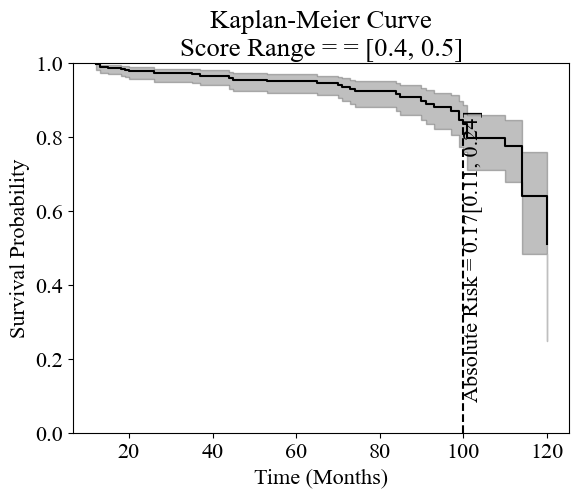

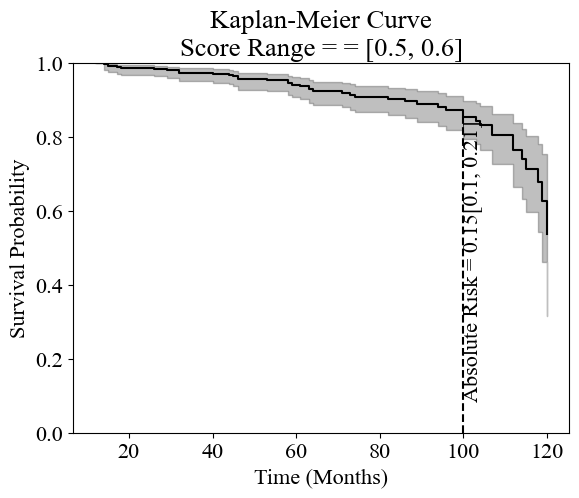

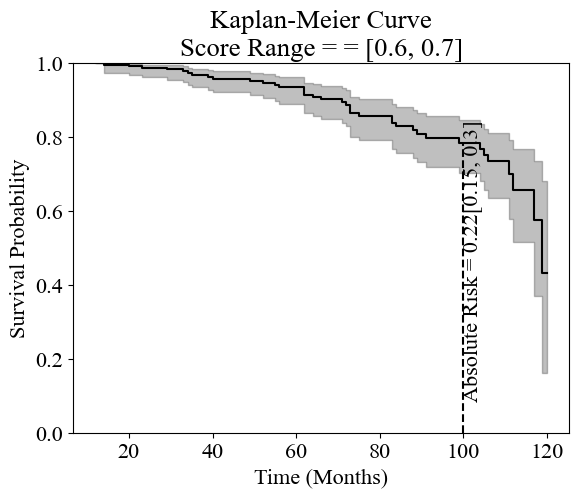

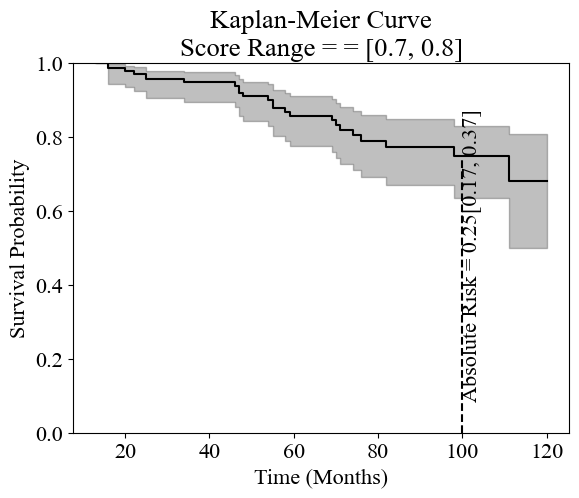

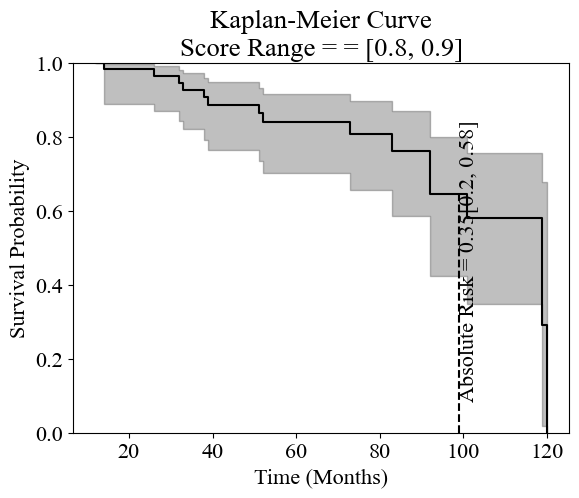

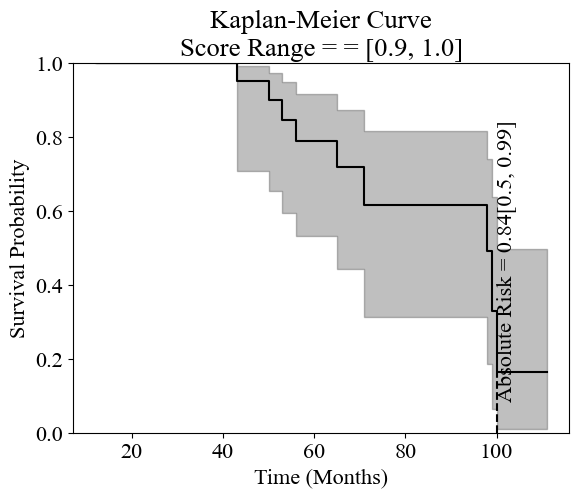

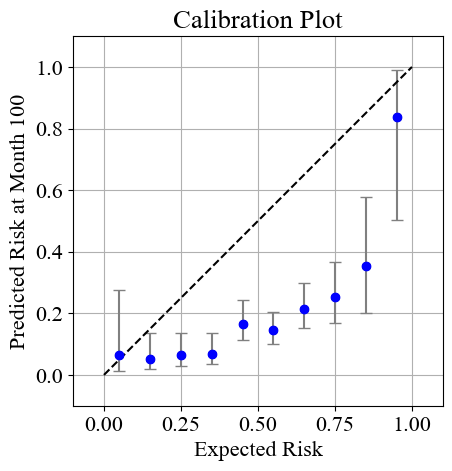

In [7]:
################ Calibration Plot ###########
prediced_risk_at_month = 100

predicted_risk = []
predicred_risk_ci = []
for i in np.arange(0,1,0.1):
    score_range = [np.round(i,2),np.round(i+0.1,2)]
    event_range = event[np.logical_and(model_score>=score_range[0] , model_score<score_range[1])]
    time_range = time[np.logical_and(model_score>=score_range[0] , model_score<score_range[1])]
    xx, yy, conf_int = kaplan_meier_estimator(event_range, time_range, conf_type="log-log")
    idx = int(np.argmin(np.abs(xx-prediced_risk_at_month)))
    absolute_prob = yy[idx]
    absolute_prob_ci = [conf_int[1,idx], conf_int[0,idx]]
    
    plt.figure()
    plt.plot([xx[idx],xx[idx]],[0,absolute_prob],'--k')
    plt.text(xx[idx],0.1,'Absolute Risk = '+str(np.round(1-absolute_prob,2))+'['+str(np.round(1-absolute_prob_ci[0],2))+', '+str(np.round(1-absolute_prob_ci[1],2))+']', rotation = 90, c = 'k')
    plt.step(xx, yy, where="post", color = 'k')
    plt.fill_between(xx, conf_int[0], conf_int[1], color = 'k', alpha=0.25, step="post")
    plt.ylim(0, 1)
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.title('Kaplan-Meier Curve'+'\n'+'Score Range = = '+str(score_range))
    plt.show()    
    predicted_risk.append(1-absolute_prob)
    predicred_risk_ci.append([1-absolute_prob_ci[0],1-absolute_prob_ci[1]])
    del xx, yy, conf_int,score_range,event_range,time_range,absolute_prob,idx
predicred_risk_ci = np.array(predicred_risk_ci).T
predicred_risk_ci[0,:]= predicted_risk-predicred_risk_ci[0,:]
predicred_risk_ci[1,:]= predicred_risk_ci[1,:]-predicted_risk

plt.scatter(np.arange(0.05,1.05,0.1), predicted_risk, c = 'k', s = 30)
plt.errorbar(np.arange(0.05,1.05,0.1), predicted_risk, yerr=predicred_risk_ci, fmt='o', color='b', ecolor='gray', capsize=4, label='Prediction')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), '--k')
plt.grid('on')
plt.xlabel('Expected Risk')
plt.ylabel('Predicted Risk at Month '+str(prediced_risk_at_month))
plt.title('Calibration Plot')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Hazard Ratio = 14.94


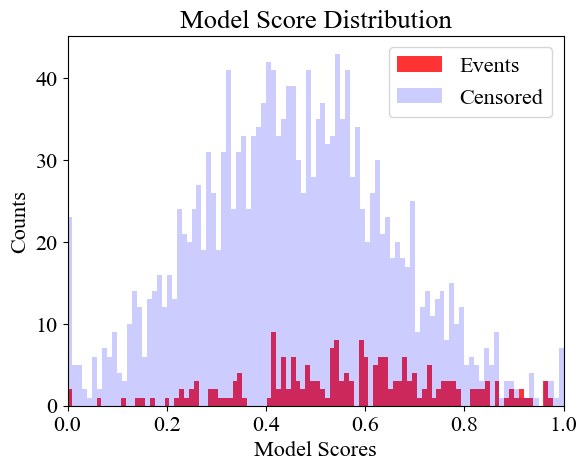

In [8]:
################ Cox Regression Model ###########
x = pd.DataFrame(model_score, columns=["Algorithm Score"])
y = Surv.from_arrays(event=event, time=time)
pipe = Pipeline([('cox_model', CoxPHSurvivalAnalysis())])
pipe.fit(x, y)
print('Hazard Ratio = '+str(np.round(np.exp(pipe['cox_model'].coef_)[0],2)))
del x, y

plt.figure()
plt.hist(model_score[event==1],100, facecolor = 'r', alpha = 0.8)
plt.hist(model_score[event==0],100, facecolor = 'b', alpha = 0.2)
plt.legend(['Events','Censored'])
plt.xlim([0,1])
plt.title('Model Score Distribution')
plt.xlabel('Model Scores')
plt.ylabel('Counts')
plt.show()